# Part A1: Data Preparation

This section loads the complete MNIST dataset using `torchvision`. We combined the training and testing sets, then performed a stratified 60/20/20 split to create our training, validation, and test sets. Finally, we set up `DataLoaders` for each set to feed the data to our models in batches.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Lambda(lambda x: torch.flatten(x))
                             ])

train_set=torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set=torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_set = ConcatDataset([train_set, test_set])

targets= torch.cat([train_set.targets, test_set.targets])
indices = np.arange(len(data_set))

train_indices, temp_indices, _, temp_targets = train_test_split(
    indices, targets, test_size=0.4, stratify=targets, random_state=42)
val_indices, test_indices, _, _ = train_test_split(
    temp_indices, temp_targets, test_size=0.5, stratify=temp_targets, random_state=42)

train_subset = Subset(data_set, train_indices)
val_subset = Subset(data_set, val_indices)
test_subset = Subset(data_set, test_indices)

BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_subset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.85MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 368kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.16MB/s]


# Part A2: Logistic Regression (Binary)

Here, we built our first model: a "from-scratch" Logistic Regression classifier. We first filtered the data to only include digits 0 and 1. We then defined our own weights (W), bias (b), `sigmoid` function, and `binary_cross_entropy` loss. We trained the model using a manual gradient descent loop and plotted the loss and accuracy curves.

In [ ]:
def filter_binary_digits(loader, digit1=0, digit2=1, shuffle_data=False):
    images_list = []
    labels_list = []

    for images, labels in loader:
        mask = (labels == digit1) | (labels == digit2)

        if mask.any():
            images_list.append(images[mask])
            new_labels = labels[mask]
            new_labels[new_labels == digit1] = 0
            new_labels[new_labels == digit2] = 1
            labels_list.append(new_labels)

    all_images = torch.cat(images_list, dim=0)
    all_labels = torch.cat(labels_list, dim=0)

    all_labels = all_labels.float().view(-1, 1)

    new_dataset = TensorDataset(all_images, all_labels)

    new_loader = DataLoader(new_dataset, batch_size=loader.batch_size, shuffle=shuffle_data)

    return new_loader


train_loader_01 = filter_binary_digits(train_loader, 0, 1, shuffle_data=True)
val_loader_01 = filter_binary_digits(val_loader, 0, 1, shuffle_data=False)
test_loader_01 = filter_binary_digits(test_loader, 0, 1, shuffle_data=False)



n_features = 784
n_outputs = 1

W = torch.randn(n_features, n_outputs, requires_grad=True)
b = torch.zeros(n_outputs, requires_grad=True)

learning_rate = 0.01
num_epochs = 20

def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def binary_cross_entropy(y_pred, y_true):
    epsilon = 1e-7
    loss = -(y_true * torch.log(y_pred + epsilon) + (1 - y_true) * torch.log(1 - y_pred + epsilon))
    return torch.mean(loss)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(num_epochs):
    train_loss_epoch = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader_01:
        z = torch.matmul(images, W) + b
        y_pred = sigmoid(z)

        loss = binary_cross_entropy(y_pred, labels)

        loss.backward()

        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

            W.grad.zero_()
            b.grad.zero_()

        train_loss_epoch += loss.item() * images.size(0)
        predicted = (y_pred > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    val_loss_epoch = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader_01:
            z = torch.matmul(images, W) + b
            y_pred = sigmoid(z)

            loss = binary_cross_entropy(y_pred, labels)

            val_loss_epoch += loss.item() * images.size(0)
            predicted = (y_pred > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_train_loss = train_loss_epoch / total_train
    avg_val_loss = val_loss_epoch / total_val
    avg_train_acc = 100 * correct_train / total_train
    avg_val_acc = 100 * correct_val / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_acc)
    val_accuracies.append(avg_val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.2f}%')


print("--- Plotting Deliverables ---")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

print("--- Final Test Set Evaluation ---")
all_preds = []
all_true = []

with torch.no_grad():
    for images, labels in test_loader_01:
        z = torch.matmul(images, W) + b
        y_pred = sigmoid(z)

        predicted = (y_pred > 0.5).float()

        all_preds.extend(predicted.numpy())
        all_true.extend(labels.numpy())

test_accuracy = 100 * (np.array(all_preds) == np.array(all_true)).mean()
print(f'Final Test Accuracy: {test_accuracy:.2f}%')

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Digit 0', 'Digit 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()

# Part A3: Softmax Regression (Multi-class)

In this part, we expanded our model to classify all 10 digits (0-9). We used the full, original `DataLoaders`. We built a new "from-scratch" Softmax Regression model, defining our own `softmax` function and `cross_entropy_loss`. After training, we plotted the results and generated a full 10x10 confusion matrix to evaluate its performance on all classes.

Starting Softmax Regression training...
Epoch [1/20], Train Loss: 1.1112, Train Acc: 78.01%, Val Loss: 0.7161, Val Acc: 84.67%
Epoch [2/20], Train Loss: 0.6183, Train Acc: 85.99%, Val Loss: 0.5574, Val Acc: 86.66%
Epoch [3/20], Train Loss: 0.5176, Train Acc: 87.36%, Val Loss: 0.4931, Val Acc: 87.73%
Epoch [4/20], Train Loss: 0.4690, Train Acc: 88.19%, Val Loss: 0.4571, Val Acc: 88.20%
Epoch [5/20], Train Loss: 0.4391, Train Acc: 88.72%, Val Loss: 0.4336, Val Acc: 88.61%
Epoch [6/20], Train Loss: 0.4183, Train Acc: 89.05%, Val Loss: 0.4165, Val Acc: 89.01%
Epoch [7/20], Train Loss: 0.4029, Train Acc: 89.31%, Val Loss: 0.4032, Val Acc: 89.32%
Epoch [8/20], Train Loss: 0.3908, Train Acc: 89.55%, Val Loss: 0.3929, Val Acc: 89.54%
Epoch [9/20], Train Loss: 0.3810, Train Acc: 89.76%, Val Loss: 0.3847, Val Acc: 89.65%
Epoch [10/20], Train Loss: 0.3727, Train Acc: 89.89%, Val Loss: 0.3774, Val Acc: 89.76%
Epoch [11/20], Train Loss: 0.3658, Train Acc: 90.12%, Val Loss: 0.3717, Val Acc: 89.89%
E

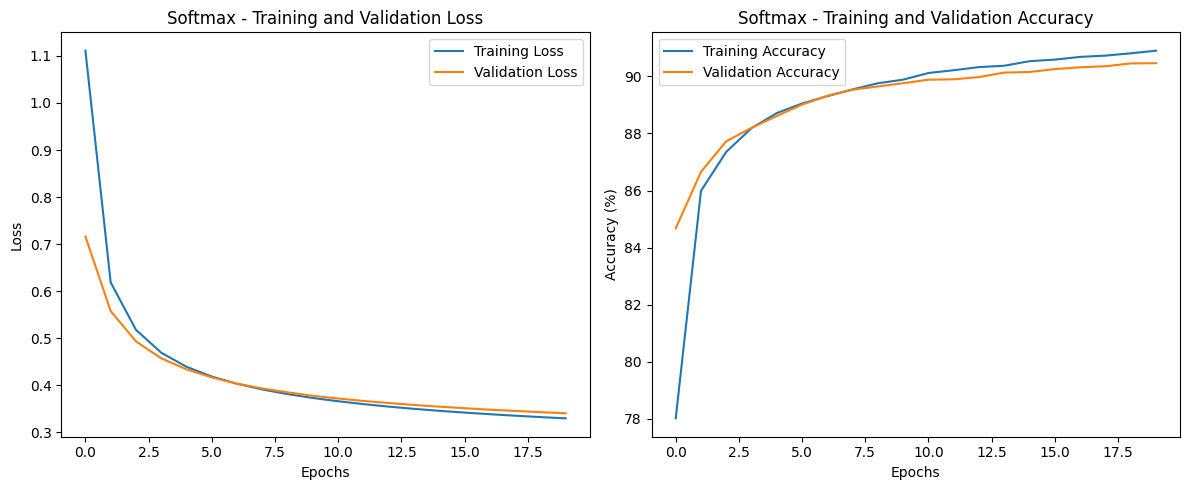

--- Final Softmax Test Set Evaluation ---
Final Softmax Test Accuracy: 90.51%

--- Confusion Matrix (Softmax) ---


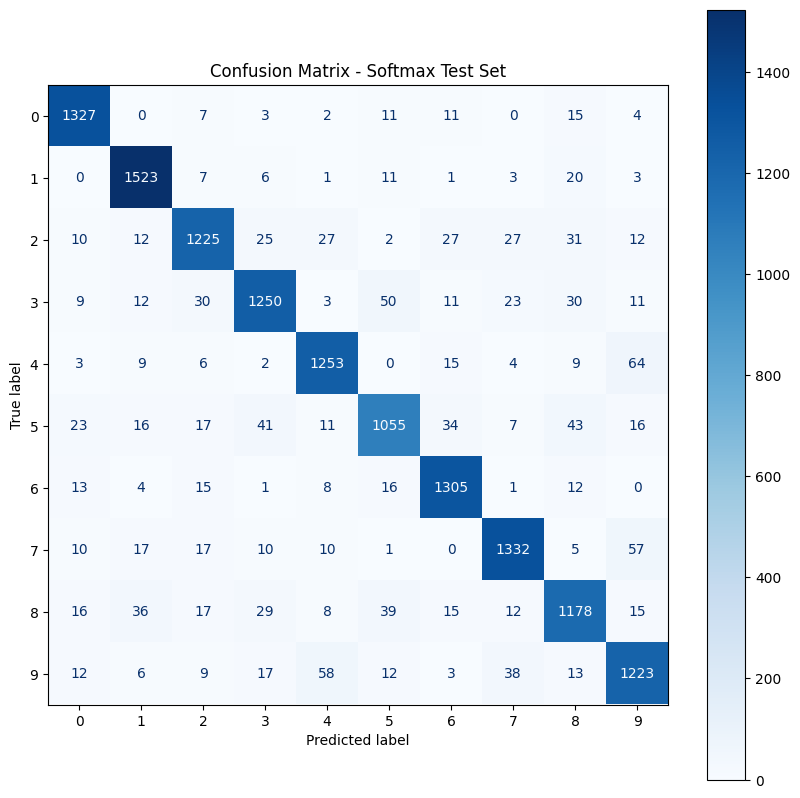


--- Per-class Accuracy Analysis (Softmax) ---
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1380
           1       0.93      0.97      0.95      1575
           2       0.91      0.88      0.89      1398
           3       0.90      0.87      0.89      1429
           4       0.91      0.92      0.91      1365
           5       0.88      0.84      0.86      1263
           6       0.92      0.95      0.93      1375
           7       0.92      0.91      0.92      1459
           8       0.87      0.86      0.87      1365
           9       0.87      0.88      0.87      1391

    accuracy                           0.91     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.90      0.91      0.90     14000



In [ ]:

n_features = 784
n_outputs_softmax = 10

std_dev = 1.0 / np.sqrt(n_features)
W_softmax = torch.empty(n_features, n_outputs_softmax).uniform_(-std_dev, std_dev)
W_softmax.requires_grad = True
b_softmax = torch.zeros(n_outputs_softmax, requires_grad=True)

learning_rate = 0.01
num_epochs = 20

def softmax(z):
    exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True)[0])
    return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

def cross_entropy_loss(y_pred_softmax, y_true):
    num_samples = y_true.shape[0]
    epsilon = 1e-9
    correct_class_probs = y_pred_softmax[range(num_samples), y_true]
    loss = -torch.log(correct_class_probs + epsilon)
    return torch.mean(loss)

train_losses_softmax = []
val_losses_softmax = []
train_accuracies_softmax = []
val_accuracies_softmax = []


for epoch in range(num_epochs):
    train_loss_epoch = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        z = torch.matmul(images, W_softmax) + b_softmax
        y_pred = softmax(z)
        loss = cross_entropy_loss(y_pred, labels)
        loss.backward()

        with torch.no_grad():
            W_softmax -= learning_rate * W_softmax.grad
            b_softmax -= learning_rate * b_softmax.grad
            W_softmax.grad.zero_()
            b_softmax.grad.zero_()

        train_loss_epoch += loss.item() * images.size(0)
        predicted_class = torch.argmax(z, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_class == labels).sum().item()

    val_loss_epoch = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            z = torch.matmul(images, W_softmax) + b_softmax
            y_pred = softmax(z)
            loss = cross_entropy_loss(y_pred, labels)
            val_loss_epoch += loss.item() * images.size(0)
            predicted_class = torch.argmax(z, dim=1)
            total_val += labels.size(0)
            correct_val += (predicted_class == labels).sum().item()

    avg_train_loss = train_loss_epoch / total_train
    avg_val_loss = val_loss_epoch / total_val
    avg_train_acc = 100 * correct_train / total_train
    avg_val_acc = 100 * correct_val / total_val

    train_losses_softmax.append(avg_train_loss)
    val_losses_softmax.append(avg_val_loss)
    train_accuracies_softmax.append(avg_train_acc)
    val_accuracies_softmax.append(avg_val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.2f}%')


print("--- Plotting Softmax (from-scratch) Deliverables ---")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_softmax, label='Training Loss')
plt.plot(val_losses_softmax, label='Validation Loss')
plt.title('Softmax (From-Scratch) - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_softmax, label='Training Accuracy')
plt.plot(val_accuracies_softmax, label='Validation Accuracy')
plt.title('Softmax (From-Scratch) - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

print("--- Final Softmax (from-scratch) Test Set Evaluation ---")
all_preds_softmax = []
all_true_softmax = []
with torch.no_grad():
    for images, labels in test_loader:
        z = torch.matmul(images, W_softmax) + b_softmax
        predicted_class = torch.argmax(z, dim=1)
        all_preds_softmax.extend(predicted_class.numpy())
        all_true_softmax.extend(labels.numpy())

test_accuracy_softmax = 100 * (np.array(all_preds_softmax) == np.array(all_true_softmax)).mean()
print(f'Final Softmax (From-Scratch) Test Accuracy: {test_accuracy_softmax:.2f}%')

print("\n--- Confusion Matrix (From-Scratch) ---")
cm_softmax = confusion_matrix(all_true_softmax, all_preds_softmax)
disp_softmax = ConfusionMatrixDisplay(confusion_matrix=cm_softmax, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(10, 10))
disp_softmax.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix - Softmax (From-Scratch)')
plt.show()

print("\n--- Per-class Accuracy (From-Scratch) ---")
print(classification_report(all_true_softmax, all_preds_softmax))


# --- A3: Built-in Verification ---


class SoftmaxModelBuiltIn(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SoftmaxModelBuiltIn, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

model_builtin = SoftmaxModelBuiltIn(n_features, n_outputs_softmax)
criterion_builtin = nn.CrossEntropyLoss()
optimizer_builtin = torch.optim.SGD(model_builtin.parameters(), lr=learning_rate)



for epoch in range(num_epochs):
    for images, labels in train_loader:
        outputs = model_builtin(images)
        loss = criterion_builtin(outputs, labels)

        optimizer_builtin.zero_grad()
        loss.backward()
        optimizer_builtin.step()

print("--- Final Softmax (Built-in) Test Set Evaluation ---")
correct_builtin = 0
total_builtin = 0
with torch.no_grad():
    model_builtin.eval()
    for images, labels in test_loader:
        outputs = model_builtin(images)
        _, predicted = torch.max(outputs.data, 1)
        total_builtin += labels.size(0)
        correct_builtin += (predicted == labels).sum().item()

test_accuracy_builtin = 100 * correct_builtin / total_builtin
print(f'Final Softmax (Built-in) Test Accuracy: {test_accuracy_builtin:.2f}%')


print("\n--- Comparison ---")
print(f'From-Scratch Model Accuracy: {test_accuracy_softmax:.2f}%')
print(f'Built-in Model Accuracy: {test_accuracy_builtin:.2f}%')